# Classification Prediction

In [73]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import pandas as pd
import humanize
from datetime import datetime, timedelta
import time
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [74]:
CATEGORIES = [300, 1935, 3307, 11000, 260000]
N_BUCKETS = 5

In [75]:
df = pd.read_csv("training_data.csv")
df = df.drop(columns=df.columns[0])
df.describe()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
count,1567.000000,1567.000000,1567.000000,1567.00000,1567.000000,1567.000000,1567.000000,1.567000e+03,1.567000e+03,1567.00000
mean,6431.226548,8845.504786,0.132285,585.52074,146.346522,5.017888,0.865431,2.265994e+06,8.717648e+05,585.52074
std,6553.691660,6431.073029,0.066668,89.64333,86.238083,3.686380,0.240428,1.469066e+06,5.962585e+05,89.64333
min,10.000000,10.000000,0.000000,1.00000,-29.000000,1.000000,0.000000,4.011320e+05,2.948400e+05,1.00000
25%,1738.000000,4228.000000,0.090000,600.00000,90.000000,2.235000,0.900000,1.336916e+06,6.464160e+05,600.00000
50%,3086.000000,6084.000000,0.100000,600.00000,120.000000,4.470000,0.900000,2.462132e+06,6.480240e+05,600.00000
75%,10837.000000,11382.000000,0.200000,600.00000,210.000000,6.705000,1.000000,2.659250e+06,8.208640e+05,600.00000
max,53888.000000,88166.000000,0.330000,600.00000,360.000000,25.000000,1.200000,2.096308e+07,6.051040e+06,600.00000


### Create n buckets split with even amounts of runs

In [76]:
def print_score(pred, true):
    print("Mean Squared Error:".ljust(22," "),round(mean_squared_error(true, pred),5))
    print("Mean Absolute Error:".ljust(22," "), round(mean_absolute_error(true, pred),5))
    
def convert(seconds):
    return humanize.naturaldelta(timedelta(seconds=seconds))

def show_diff(predictions,y_test,n=25):
    print("PREDICTION\t RESULT\t\t DIFFERENCE")
    print("-"*45)
    for i in range(0,n):
        print(predictions[i], "\t",y_test[i], "\t", y_test[i] - predictions[i])

def show_plots(predictions, y_test, s=4):
    plt.subplot(211)
    plt.title("Test Results and Predictions")
    plt.scatter(range(len(y_test)),y_test,s=s)
    plt.xlabel("X_test[i]")
    plt.ylabel("correct answer")
    plt.subplot(212)
    plt.scatter(range(len(predictions)),predictions,s=s)
    plt.ylabel("predictions")
    plt.show()

pred = {}
models = {}

## Remove Outliers from DataFrame
any simulations over 26000 seconds is what this just about works out to be

In [77]:
import pandas as pd
import numpy as np
from scipy import stats

df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [78]:
df.describe()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
count,1442.000000,1442.000000,1442.000000,1442.0,1442.000000,1442.000000,1442.000000,1.442000e+03,1.442000e+03,1442.0
mean,6396.604022,9099.547850,0.132053,600.0,149.556865,4.700820,0.890187,2.198703e+06,8.645024e+05,600.0
std,5750.241251,5975.171672,0.066491,0.0,86.405921,2.921946,0.201519,1.134214e+06,5.494223e+05,0.0
min,10.000000,3699.000000,0.000000,600.0,-29.000000,1.000000,0.300000,4.011320e+05,2.948400e+05,600.0
25%,1935.000000,4503.000000,0.090000,600.0,90.000000,2.235000,0.900000,1.336937e+06,6.464160e+05,600.0
50%,3307.000000,6748.000000,0.100000,600.0,120.000000,4.470000,0.900000,2.461966e+06,6.480240e+05,600.0
75%,10958.250000,11382.000000,0.200000,600.0,225.000000,6.705000,1.000000,2.659110e+06,8.208640e+05,600.0
max,25866.000000,27251.000000,0.300000,600.0,360.000000,15.000000,1.200000,5.517084e+06,2.335392e+06,600.0


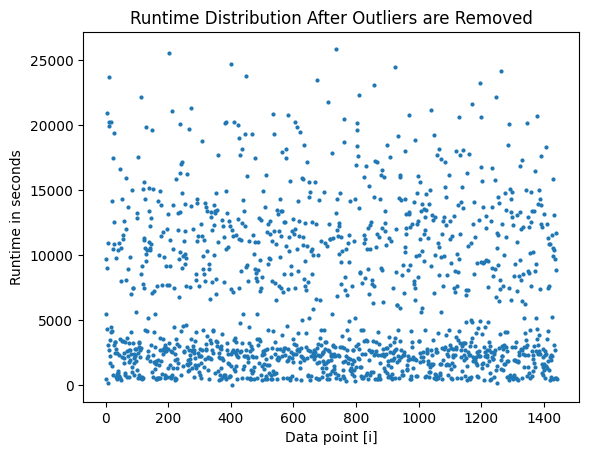

In [79]:
plt.title("Runtime Distribution After Outliers are Removed")
plt.scatter(range(len(df["runtime"])),df["runtime"],s=4)
plt.ylabel("Runtime in seconds")
plt.xlabel("Data point [i]")
plt.show()

<Axes: xlabel='runtime', ylabel='Count'>

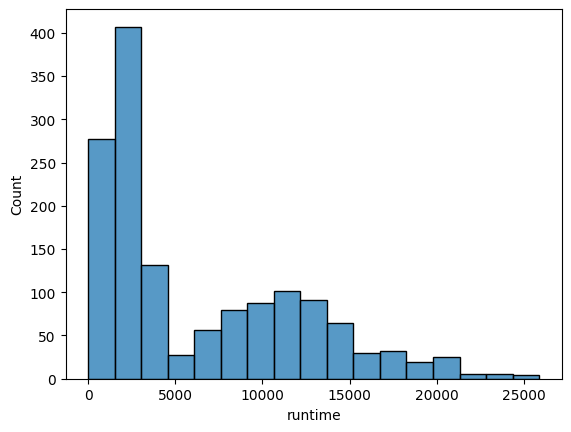

In [80]:
sns.histplot(df["runtime"])

In [81]:
sim_times = list(df["runtime"].sort_values())
bin_length = len(sim_times) // N_BUCKETS
print(N_BUCKETS)
print(len(sim_times))
print("________",bin_length)
CATEGORIES = []
current=0
for i in range(1,N_BUCKETS):
    # CATEGORIES.append(sim_times[bin_length*i])
    CATEGORIES.append(sim_times[bin_length+current])
    current += bin_length
    print(current)
CATEGORIES.append(list(sim_times)[-1])
CATEGORIES
# [1982, 2366, 3038, 789, 25866]

5
1442
________ 288
288
576
864
1152


[1602, 2664, 7072, 11969, 25866]

In [82]:
def categorize(seconds):
    global CATEGORIES
    for i in range(len(CATEGORIES)):
        if (seconds <= CATEGORIES[i]):
            return i

def print_categories():
    global CATEGORIES
    for i in range(len(CATEGORIES)):
        print(f"{convert(CATEGORIES[i])}   \t{i}")

In [83]:
runtime_categories = df.apply(lambda row: categorize(row["runtime"]), axis=1)
# df.insert(0, "runtime_ca", runtime_categories)
df["runtime_ca"] = runtime_categories
df.head()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire,runtime_ca
0,5475,4503,0.10,600,65.0,2.235,1.00,1934680,560976.0,600,2
1,9737,11382,0.05,600,90.0,4.470,0.90,2470180,1981888.0,600,3
2,501,3937,0.12,600,270.0,2.235,0.95,517424,359488.0,600,0
3,4325,4921,0.10,600,137.0,3.000,1.10,2454040,1053216.0,600,2
4,9008,14997,0.15,600,360.0,4.470,1.00,3919432,648024.0,600,3


26 minutes   	 0
44 minutes   	 1
an hour   	 2
3 hours   	 3
7 hours   	 4
[1602, 2664, 7072, 11969, 25866]


runtime_ca
0    289
4    289
2    288
3    288
1    288
Name: count, dtype: int64

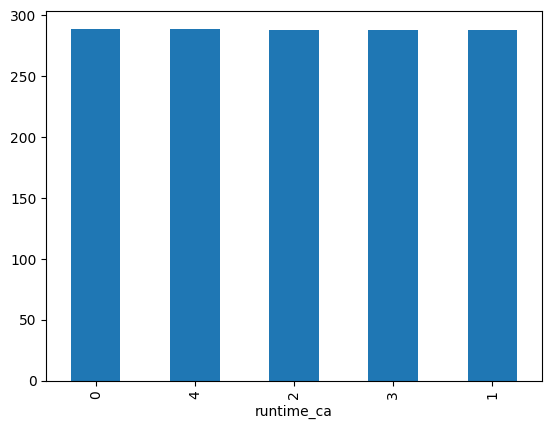

In [84]:
for i in range(len(CATEGORIES)):
    print(convert(CATEGORIES[i]),"  \t",i)
print(CATEGORIES)
df["runtime_ca"].value_counts().plot(kind="bar")
df["runtime_ca"].value_counts()

In [85]:
y = df["runtime_ca"]
X = df.drop(columns=["runtime","runtime_ca"])
X.tail()

,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
1562,4005,0.10,600,60.0,2.235,0.90,401132,294840.0,600
1563,11359,0.05,600,150.0,4.023,1.00,2470680,1981888.0,600
1564,3937,0.07,600,240.0,2.235,0.95,517488,359488.0,600
1565,27251,0.15,600,60.0,4.470,0.90,3920324,648024.0,600
1566,4005,0.10,600,90.0,2.235,0.90,404324,294840.0,600


In [86]:
TEST_RATIO = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO,random_state=42)

# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

print(len(X_train), len(X_test), len(y_train), len(y_test))

1153 289 1153 289


# Classification Approaches
- K Means clustering
- Support Vector Machines
- Decision Trees
- Logistic Regression
- Stochastic Gradient Descent
- k Nearest Neighbors
- Random Forest
- Gradient Boosting
- LGBM
- XGB
- GRBT

Ensemble Methods
- Voting Classifier


In [116]:
from sklearn.preprocessing import StandardScaler


# Standardizing the features
x_tr = StandardScaler().fit_transform(X_train)
x_te = StandardScaler().fit_transform(X_test)
X_train  = x_tr
X_test = x_te


In [117]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x_tr)
# principalComponents = pca.fit_transform(x_te)


principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,5.059003,-0.349913
1,3.966041,-0.419386
2,0.167789,0.078544
3,2.080230,-0.217493
4,0.293975,-0.057179
...,...,...
1148,1.692802,-0.248479
1149,4.656933,-0.396537
1150,-1.187982,-0.244702
1151,-0.629434,-1.896367


In [118]:
series = pd.Series([str(round(x)) for x in y_train])
finalDf = principalDf
finalDf['target'] = series


In [120]:
finalDf

,principal component 1,principal component 2,target
0,5.059003,-0.349913,3
1,3.966041,-0.419386,0
2,0.167789,0.078544,1
3,2.080230,-0.217493,2
4,0.293975,-0.057179,1
...,...,...,...
1148,1.692802,-0.248479,1
1149,4.656933,-0.396537,2
1150,-1.187982,-0.244702,2
1151,-0.629434,-1.896367,0


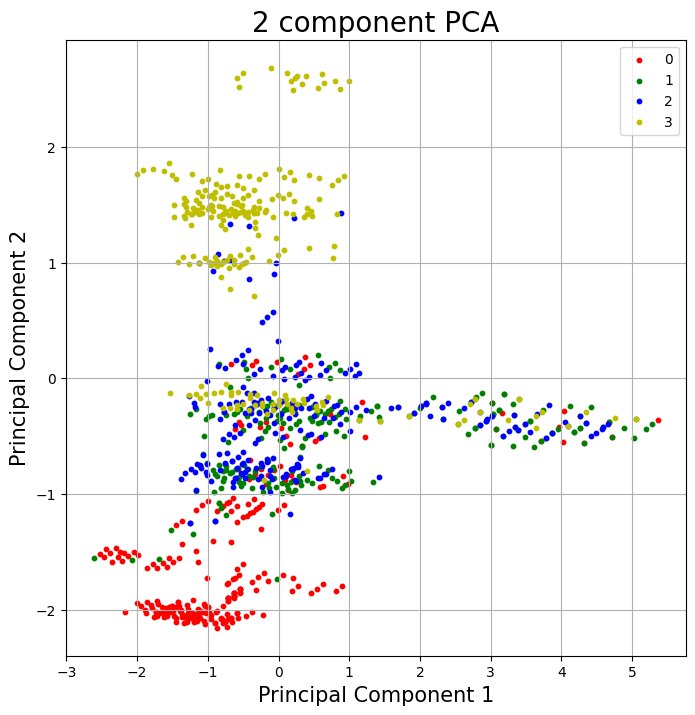

In [131]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['0','1','2','3']
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

# K Means Clustering

In [16]:
from sklearn.cluster import KMeans

# ------ experiment with cluster amount ---------- #
n_clusters = len(CATEGORIES)
# ------ experiment with cluster amount ---------- #

model = KMeans(n_clusters=n_clusters, n_init=10)
model = model.fit(X_train,y_train)

In [17]:
pred["Kmeans"] = model.predict(X_test)
models["Kmeans"] = model

In [18]:
print_score(pred["Kmeans"], y_test)

Mean Squared Error:    1.609
Mean Absolute Error:   0.95848


In [19]:
accuracy_score(y_true=y_test,y_pred=pred["Kmeans"])

0.314878892733564

15% is very bad accuracy, something must be wrong with my approach to using K means here but I am not sure so I will try another model. Could be an input data problem but I am skeptical of that

# SVM

In [20]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
model = model.fit(X_train,y_train)

In [21]:
pred["SVM"] = model.predict(X_test)
models["SVM"] = model
accuracy_score(y_true=y_test,y_pred=pred["SVM"])

0.6262975778546713

# Decision Tree Classifier

In [22]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model = model.fit(X_train, y_train)

In [23]:
pred["DecisionTree"] = model.predict(X_test)
models["DecisionTree"] = model
accuracy_score(y_true=y_test,y_pred=pred["DecisionTree"])

0.49480968858131485

# Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=400)
model = model.fit(X_train, y_train)

In [25]:
pred["LogisticRegression"] = model.predict(X_test)
models["LogisticRegression"] = model
accuracy_score(y_true=y_test,y_pred=pred["LogisticRegression"])

0.6089965397923875

# Stochastic Gradient Descent

In [26]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
model = model.fit(X_train, y_train)

In [27]:
pred["SGD"] = model.predict(X_test)
models["SGD"] = model
accuracy_score(y_true=y_test,y_pred=pred["SGD"])

0.5882352941176471

# K Nearest Neighbor

In [28]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=len(CATEGORIES))
model = model.fit(X_train, y_train)

In [29]:
pred["kNN"] = model.predict(X_test)
models["kNN"] = model
accuracy_score(y_true=y_test,y_pred=pred["kNN"])

0.6055363321799307

# Random Forest


In [30]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=110, max_features='sqrt',max_depth=7)
model = model.fit(X_train, y_train)

In [31]:
pred["RandomForest"] = model.predict(X_test)
models["RandomForest"] = model
accuracy_score(y_true=y_test,y_pred=pred["RandomForest"])

0.629757785467128

# Gradient Boosting

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(max_depth=3, learning_rate=0.1, n_estimators = 35)
model = model.fit(X_train, y_train)

In [33]:
pred["GradientBoosting"] = model.predict(X_test)
models["GradientBoosting"] = model

accuracy_score(y_true=y_test,y_pred=pred["GradientBoosting"])

0.5916955017301038

# LGBM

In [34]:
# !pip3 install --user lightgbm

In [35]:
from lightgbm import LGBMClassifier
# ----------------- #
n = 100
# ----------------- #
model = LGBMClassifier(n_estimators = n)
model = model.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 1153, number of used features: 7
[LightGBM] [Info] Start training from score -1.569484
[LightGBM] [Info] Start training from score -1.656495
[LightGBM] [Info] Start training from score -1.629588
[LightGBM] [Info] Start training from score -1.573659
[LightGBM] [Info] Start training from score -1.620777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [36]:
pred["LGBM"] = model.predict(X_test)
models["LGBM"] = model

accuracy_score(y_true=y_test,y_pred=pred["LGBM"])

0.5570934256055363

# XGB

In [37]:
# !pip3 install --user xgboost

In [38]:
from xgboost.sklearn import XGBClassifier
# ----------------- #
n = 100
# ----------------- #
model = XGBClassifier(n_estimators = n)
model = model.fit(X_train, y_train)

In [39]:
pred["XGB"] = model.predict(X_test)
models["XGB"] = model

accuracy_score(y_true=y_test,y_pred=pred["XGB"])

0.6055363321799307

# Naive Bayes

Naive Bayes model might help

In [40]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model = model.fit(X_train, y_train)

In [41]:
pred["GaussianNB"] = model.predict(X_test)
models["GaussinNB"] = model

accuracy_score(y_true=y_test,y_pred=pred["GaussianNB"])

0.5432525951557093

# Extra Tree Classifier

In [42]:
from sklearn.tree import ExtraTreeClassifier

model = ExtraTreeClassifier(random_state=0)
model = model.fit(X_train, y_train)

In [43]:
pred["Extra tree"] = model.predict(X_test)
models["Extra tree"] = model

accuracy_score(y_true=y_test,y_pred=pred["Extra tree"])

0.5432525951557093

# Scikit-learn's neural nets

## Multi Layer Perceptron

In [44]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(solver='lbfgs', alpha=1e-5)

model.fit(X_train, y_train)

/root/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, solver='lbfgs')

In [45]:
pred["MLP"] = model.predict(X_test)
models["MLP"] = model

accuracy_score(y_true=y_test,y_pred=pred["MLP"])

0.5743944636678201

# Gaussian Process

In [51]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(1.0)
model = GaussianProcessClassifier(kernel=kernel)
                          
# This takes a while to run
model.fit(X_train, y_train)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

Uncomment these

In [52]:
pred["GPC"] = model.predict(X_test)
models["GPC"] = model

accuracy_score(y_true=y_test,y_pred=pred["GPC"])

0.6228373702422145

# Ensemble Learning
voting classifier to predict based on votes from multiple previous classifiers

## Voting Classifier With Hard Voting

In [53]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators = [
        ('svc',models['SVM']),
        ('lr',models['LogisticRegression']),
        ('rf',models['RandomForest']),
        ('kNN',models['kNN']),
        ('dt',models['DecisionTree']),
        ('sgd',models['SGD']),
        ('XGB',models['XGB']),
        ('gradient',models['GradientBoosting'])
    ],
    voting='hard',
)

In [54]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('svc', SVC()),
                             ('lr', LogisticRegression(max_iter=400)),
                             ('rf',
                              RandomForestClassifier(max_depth=7,
                                                     n_estimators=110)),
                             ('kNN', KNeighborsClassifier()),
                             ('dt', DecisionTreeClassifier()),
                             ('sgd', SGDClassifier()),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob',
                                            predictor=None, ...)),
                             ('gradient',
                              GradientBoostingClassifier(n_estimators=35))])

In [55]:
pred["Voting"] = model.predict(X_test)
models["Voting"] = model

accuracy_score(y_true=y_test,y_pred=pred["Voting"])

0.6228373702422145

## Voting Classifier with Probability Predictions

In [56]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators = [
        # ('random',prob_models['random']),
        # ('logistic',prob_models['logistic']),
        ('svc',models['SVM']),
        ('lr',models['LogisticRegression']),
        ('rf',models['RandomForest']),
        ('kNN',models['kNN']),
        ('dt',models['DecisionTree']),
        ('sgd',models['SGD']),
        ('XGB',models['XGB']),
        ('gradient',models['GradientBoosting'])
    ],
    voting='soft'
)
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('svc', SVC()),
                             ('lr', LogisticRegression(max_iter=400)),
                             ('rf',
                              RandomForestClassifier(max_depth=7,
                                                     n_estimators=110)),
                             ('kNN', KNeighborsClassifier()),
                             ('dt', DecisionTreeClassifier()),
                             ('sgd', SGDClassifier()),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob',
                                            predictor=None, ...)),
                             ('gradient',
                              GradientBoostingClassifier(n_estimators=35))],
                 voting='soft')

In [57]:
pred["SoftVoting"] = model.predict(X_test)
models["SoftVoting"] = model
accuracy_score(y_true=y_test,y_pred=pred["SoftVoting"])

0.6228373702422145

not working yet, need to change the models to support probability

# Hyperparameter tuning for best models above

## Random Forests

In [58]:
L = list(np.linspace(4,10,5,dtype=np.int32))
L.append(None)
L
param_grid = [{
    'n_estimators': np.linspace(102,110,4,dtype=np.int32),
    'max_features': ["sqrt", "log2", None, 9],
    'max_depth': L,
}]
# {'max_features': 'sqrt', 'n_estimators': 104}
# {'max_features': 9, 'n_estimators': 108}
# {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 110}

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=3,verbose=1)
# grid_search.fit(X_train, y_train)

In [60]:
# grid_search.best_params_

In [61]:
from sklearn.ensemble import RandomForestClassifier
# ----------------- #
n = 35
# ----------------- #
model = RandomForestClassifier(n_estimators=110, max_features='sqrt',max_depth=7)
model = model.fit(X_train, y_train)

In [62]:
pred["RandomForest"] = model.predict(X_test)
models["RandomForest"] = model
accuracy_score(y_true=y_test,y_pred=pred["RandomForest"])

0.643598615916955

In [63]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 110,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

From this grid search testing, I found the best parameters to give to the random forest classifier, getting a new best of 74% accuracy!

## GradientBoosting

In [64]:
param_grid = [{
    'n_estimators': [34,35],
    # 'max_features': ["sqrt", "log2", None, 9],
    'max_depth': [3,4,5,6,7,8,9,10],
    'learning_rate': [0.1],  
}]

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = GradientBoostingClassifier()
grid_search = GridSearchCV(model, param_grid, cv=3,verbose=1)
# grid_search.fit(X_train, y_train)

In [66]:
# grid_search.best_params_

In [67]:
# pred["GradientBoosting"] = m.predict(X_test)
# models["GradientBoosting"] = model

# accuracy_score(y_true=y_test,y_pred=pred["GradientBoosting"])

# Compare Models

In [68]:
# compare = pd.DataFrame(pred)
compare = pd.DataFrame({
    "name":pred.keys(), 
    "accuracy":np.nan,
    "mse":np.nan,
})
compare = compare.set_index("name")

In [69]:
compare["accuracy"] = compare.apply(lambda row: accuracy_score(y_pred=pred[row.name],y_true=y_test)*100,axis=1)
compare["mse"] = compare.apply(lambda row: mean_squared_error(y_pred=pred[row.name],y_true=y_test),axis=1)
compare["mean absolute"] = compare.apply(lambda row: mean_absolute_error(y_pred=pred[row.name],y_true=y_test),axis=1)

### So how do the models stack up to each other?

In [71]:
compare.sort_values(by='accuracy',ascending=False)

,accuracy,mse,mean absolute
name,,,
RandomForest,64.359862,0.505190,0.401384
SVM,62.629758,0.525952,0.422145
GPC,62.283737,0.519031,0.422145
Voting,62.283737,0.519031,0.422145
SoftVoting,62.283737,0.519031,0.422145
LogisticRegression,60.899654,0.574394,0.449827
kNN,60.553633,0.633218,0.467128
XGB,60.553633,0.588235,0.456747
GradientBoosting,59.169550,0.865052,0.532872


so Kmeans is pretty bad, Random Forest, Gradient Boosting and GRBT appear to be the best

the voting ensemble also does well, just about matching the performance of any one other model. I hoped it would exceed the individuals but it has not yet

### Next Step
Try out the voting ensemble with soft voting, utilizing probabilities. This will require changing the models it uses to do probability voting and have the `predict_proba()` method

In [72]:
print_categories()

26 minutes   	0
44 minutes   	1
an hour   	2
3 hours   	3
7 hours   	4


# Save Models

In [65]:
import pickle
m = {
    'GradientBoosting': models['GradientBoosting'],
    'RandomForest': models['RandomForest'],
    'MLP': models['MLP'],
    'Voting':models['Voting']
}

with open('models.pkl', 'wb') as file:
    pickle.dump(m, file)

In [66]:
X_test.describe()

,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
count,289.000000,289.000000,289.0,289.000000,289.000000,289.000000,2.890000e+02,2.890000e+02,289.0
mean,9342.259516,0.139239,600.0,138.339100,4.670197,0.868166,2.144727e+06,8.763458e+05,600.0
std,6189.287956,0.066344,0.0,81.418815,2.782805,0.210094,1.121511e+06,5.706791e+05,0.0
min,3699.000000,0.030000,600.0,0.000000,1.341000,0.300000,4.012760e+05,2.948400e+05,600.0
25%,4503.000000,0.100000,600.0,90.000000,2.235000,0.900000,1.336856e+06,6.464160e+05,600.0
50%,6640.000000,0.120000,600.0,120.000000,4.470000,0.900000,2.461848e+06,6.480240e+05,600.0
75%,11382.000000,0.200000,600.0,210.000000,6.705000,1.000000,2.658908e+06,8.208640e+05,600.0
max,27251.000000,0.300000,600.0,360.000000,15.000000,1.200000,4.674148e+06,1.981888e+06,600.0


In [67]:
X_test.head()

,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
443,19838,0.20,600,60.0,4.470,0.9,452208,294840.0,600
643,5945,0.25,600,90.0,4.470,1.0,1336740,646416.0,600
590,19838,0.15,600,60.0,4.470,0.9,452192,294840.0,600
69,27251,0.15,600,60.0,6.705,0.9,3920864,648024.0,600
406,16374,0.07,600,240.0,2.235,1.0,2427584,1981888.0,600


note: look into principal component analysis

# Charts in progress

In [68]:
a = pd.Series(pred["LGBM"]).value_counts()
b = pd.Series(y_test).value_counts()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
343,Gentoo,Biscoe,49.9,16.1,213.0,5400.0,Male


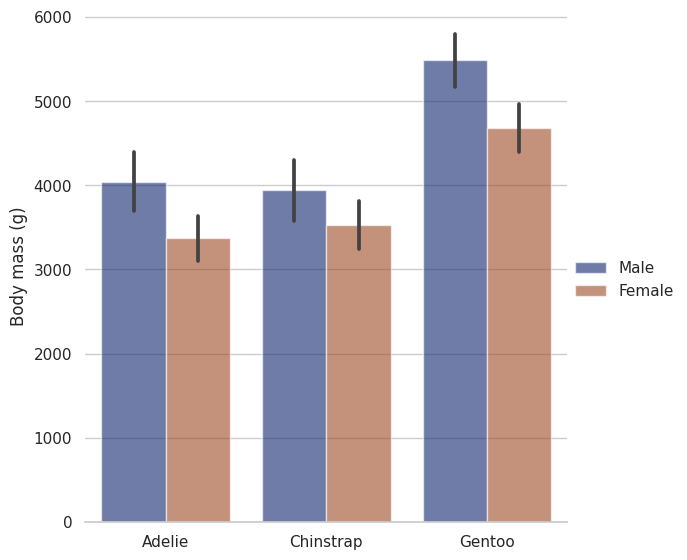

In [69]:
sns.set_theme(style="whitegrid")

penguins = sns.load_dataset("penguins")
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=penguins, kind="bar",
    x="species", y="body_mass_g", hue="sex",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")
penguins.tail(5)

In [70]:
model_val_counts = pd.Series(pred["XGB"]).value_counts()
y_test_val_counts = pd.Series(y_test).value_counts()
c = dict(model_val_counts)
d = dict(y_test_val_counts)

merged_dict = {}
for i in range(0,len(c)):
    merged_dict[i] = [c[i], d[i]]

data = pd.DataFrame(merged_dict)
# data["hue"] = [0,1]
data = data.T

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
343,Gentoo,Biscoe,49.9,16.1,213.0,5400.0,Male


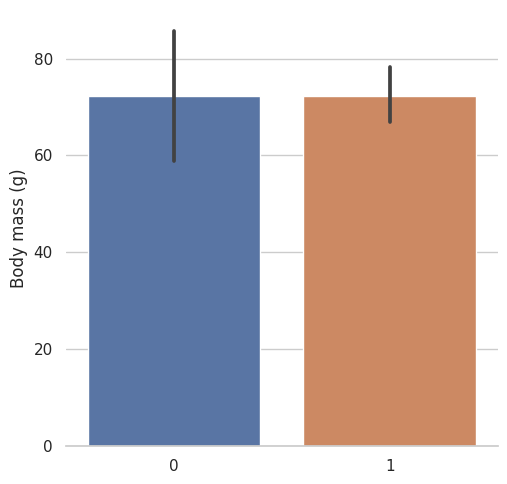

In [71]:
sns.set_theme(style="whitegrid")

penguins = sns.load_dataset("penguins")
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=data, kind="bar"
    # x="species", y="body_mass_g", hue="sex",
    # errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
# g.legend.set_title("")
penguins.tail(5)


In [72]:
data

,0,1
0,64,65
1,93,81
2,57,73
3,75,70
